# Interactive train and test with WER in sentence length order

## Setup

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/catskills/Desktop/openasr20/end2end_asr_pytorch')

In [3]:
import os
os.environ['IN_JUPYTER']='True'

In [4]:
%matplotlib inline
import matplotlib.pylab as plt

In [5]:
!rm -rf runs

In [6]:
from chunk_size import chunk_size
from glob import glob
from models.asr.transformer import Transformer, Encoder, Decoder
from torch.autograd import Variable
from torch.cuda.amp import GradScaler, autocast
from utils import constant
from utils.data_loader import SpectrogramDataset, AudioDataLoader, BucketingSampler
from utils.functions import save_model, load_model, init_transformer_model, init_optimizer
from utils.lstm_utils import LM
from utils.metrics import calculate_metrics, calculate_cer, calculate_wer, calculate_cer_en_zh
from utils.optimizer import NoamOpt
import json, logging, math, os, random, time, torch, sys, random
import numpy as np
import torch.nn as nn
from Trainer import Trainer

9842 chunks


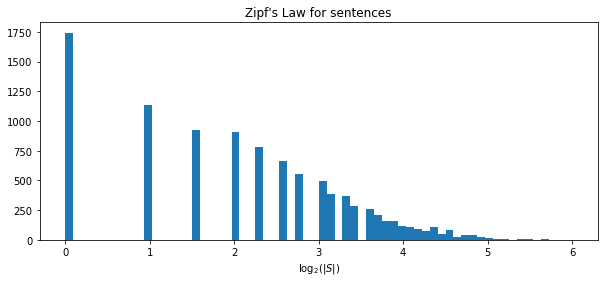

In [7]:
language='amharic'
stage='NIST'
chunks = list(sorted(glob(f'{stage}/openasr20_{language}/build/transcription_split/*.txt')))
print(len(chunks), 'chunks')
size_chunks=list(sorted([chunk_size(fn) for fn in chunks]))
size_chunk_files={x:[] for x,y in size_chunks}
for x,y in size_chunks:
    size_chunk_files[x].append(y)
size_chunk_distribution={x:0 for x,y in size_chunks}
for x,y in size_chunks:
    size_chunk_distribution[x] += 1
plt.figure(figsize=(10,4))
plt.hist([np.log2(x) for x,y in size_chunks], bins=max(size_chunk_distribution))
plt.title("Zipf's Law for sentences")
plt.xlabel("$\log_2(|S|)$");

In [8]:
sizes=[x for x in size_chunk_files]

In [10]:
chunks[0:2]

['NIST/openasr20_amharic/build/transcription_split/BABEL_OP3_307_14229_20140503_233516_inLine_000_2.715_3.225.txt',
 'NIST/openasr20_amharic/build/transcription_split/BABEL_OP3_307_14229_20140503_233516_inLine_001_5.215_8.035.txt']

In [9]:
size_chunk_files[sizes[-1]]

['NIST/openasr20_amharic/build/transcription_split/BABEL_OP3_307_61971_20140811_182130_outLine_025_155.085_178.495.txt']

In [10]:
L=[]
for text in size_chunk_files[1]+size_chunk_files[2]+size_chunk_files[3]+size_chunk_files[4]:
    audio=text.replace('transcription','audio').replace('txt', 'wav')
    L.append(f'{audio},{text}')
random.shuffle(L)

In [11]:
print(f'{len(L)} samples in training set of length 1 to 4 covers {100*len(L)/len(chunks):.2f}%')

4706 samples in training set of length 1 to 4 covers 47.82%


In [12]:
manifest_file_path=f'analysis/{language}/size_1.csv'
with open(manifest_file_path,'w') as f:
    f.write('\n'.join(L))

model_dir=f'save/{language}_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4'

args=constant.args
args.continue_from=None
args.cuda = True
args.labels_path = f'analysis/{language}/{language}_characters.json'
args.lr = 1e-4
args.name = f'{language}_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4'
args.save_folder = f'save'
args.epochs = 5
args.save_every = 1
args.feat_extractor = f'vgg_cnn'
args.dropout = 0.1
args.num_layers = 4
args.num_heads = 8
args.dim_model = 512
args.dim_key = 64
args.dim_value = 64
args.dim_input = 161
args.dim_inner = 2048
args.dim_emb = 512
args.shuffle=True
args.min_lr = 1e-6
args.k_lr = 1
args.sample_rate=8000
args.train_manifest_list = [manifest_file_path]
args.continue_from=f'{model_dir}/best_model.th'

args.augment=True

audio_conf = dict(sample_rate=args.sample_rate,
                  window_size=args.window_size,
                  window_stride=args.window_stride,
                  window=args.window,
                  noise_dir=args.noise_dir,
                  noise_prob=args.noise_prob,
                  noise_levels=(args.noise_min, args.noise_max))

with open(args.labels_path, 'r') as label_file:
    labels = str(''.join(json.load(label_file)))

# add PAD_CHAR, SOS_CHAR, EOS_CHAR
labels = constant.PAD_CHAR + constant.SOS_CHAR + constant.EOS_CHAR + labels
label2id, id2label = {}, {}
count = 0
for i in range(len(labels)):
    if labels[i] not in label2id:
        label2id[labels[i]] = count
        id2label[count] = labels[i]
        count += 1
    else:
        print("multiple label: ", labels[i])

if constant.args.continue_from:
        model, opt, epoch, metrics, loaded_args, label2id, id2label = load_model(
            constant.args.continue_from)
        start_epoch = epoch  # index starts from zero
        verbose = constant.args.verbose
else:
    model = init_transformer_model(constant.args, label2id, id2label)
    opt = init_optimizer(constant.args, model, "noam")

start_epoch = epoch
metrics = None
loaded_args = None
verbose = True

constant.USE_CUDA=True

In [13]:
train_data = SpectrogramDataset(audio_conf, manifest_filepath_list=args.train_manifest_list, 
                                label2id=label2id, normalize=True, augment=args.augment)

In [14]:
loss_type = args.loss
model = model.cuda(0)
num_epochs = start_epoch + 1000

## Training

In [ ]:
args.batch_size = 9
train_sampler = BucketingSampler(train_data, batch_size=args.batch_size)
train_loader = AudioDataLoader(train_data, num_workers=args.num_workers, batch_sampler=train_sampler)

In [ ]:
trainer = Trainer()

In [ ]:
start_epoch, num_epochs

In [ ]:
trainer.train(model, train_loader, train_sampler, opt, loss_type, start_epoch, num_epochs, label2id, id2label, metrics)

## Eval

In [15]:
args.batch_size = 8
train_sampler = BucketingSampler(train_data, batch_size=args.batch_size)
train_loader = AudioDataLoader(train_data, num_workers=args.num_workers, batch_sampler=train_sampler)

In [16]:
args.verbose = True

In [17]:
smoothing = constant.args.label_smoothing

In [18]:
model.eval();

In [19]:
R = []

valid_loader = train_loader
total_valid_loss, total_valid_cer, total_valid_wer, total_valid_char, total_valid_word = 0, 0, 0, 0, 0
for i, (data) in enumerate(valid_loader):
    src, tgt, src_percentages, src_lengths, tgt_lengths = data
    src = src.cuda()
    tgt = tgt.cuda()
    with autocast():
        pred, gold, hyp_seq, gold_seq = model(src, src_lengths, tgt, verbose=False)

    seq_length = pred.size(1)
    sizes = Variable(src_percentages.mul_(int(seq_length)).int(), requires_grad=False)

    loss, num_correct = calculate_metrics(
        pred, gold, input_lengths=sizes, target_lengths=tgt_lengths, smoothing=smoothing, loss_type=loss_type)

    if loss.item() == float('Inf'):
        logging.info("Found infinity loss, masking")
        loss = torch.where(loss != loss, torch.zeros_like(loss), loss) # NaN masking
        continue

    try: # handle case for CTC
        strs_gold, strs_hyps = [], []
        for ut_gold in gold_seq:
            str_gold = ""
            for x in ut_gold:
                if int(x) == constant.PAD_TOKEN:
                    break
                str_gold = str_gold + id2label[int(x)]
            strs_gold.append(str_gold)
        for ut_hyp in hyp_seq:
            str_hyp = ""
            for x in ut_hyp:
                if int(x) == constant.PAD_TOKEN:
                    break
                str_hyp = str_hyp + id2label[int(x)]
            strs_hyps.append(str_hyp)
    except Exception as e:
        print(e)
        logging.info("NaN predictions")
        continue

    for j in range(len(strs_hyps)):
        strs_hyps[j] = strs_hyps[j].replace(constant.SOS_CHAR, '').replace(constant.EOS_CHAR, '')
        strs_gold[j] = strs_gold[j].replace(constant.SOS_CHAR, '').replace(constant.EOS_CHAR, '')
        cer = calculate_cer(strs_hyps[j].replace(' ', ''), strs_gold[j].replace(' ', ''))
        wer = calculate_wer(strs_hyps[j], strs_gold[j])
        success = 'SUCCESS' if strs_gold[j] == strs_hyps[j] else ''
        print(f'[{j}] cer {cer} wer {wer} gold {strs_gold[j]}:{len(strs_gold[j])} hyp {strs_hyps[j]}:{len(strs_hyps[j])} {success}')
        R.append((cer, wer, strs_gold[j], strs_hyps[j], success))
        total_valid_cer += cer
        total_valid_wer += wer
        total_valid_char += len(strs_gold[j].replace(' ', ''))
        total_valid_word += len(strs_gold[j].split(" "))

    total_valid_loss += loss.item()

[0] cer 3 wer 2 gold ዛሬ እንመለሳለን እንመለሳለን:18 hyp ዛሬ ታንመለለለን እንመለንለን:18 
[1] cer 2 wer 2 gold የለም ብቻዬን ነኝ ቢሮ:14 hyp የለም ብቻዬም የኝ ቢሮ:14 
[2] cer 2 wer 2 gold እሱ አባይነው ያለው እንደ:16 hyp እሱ አባርነው ያለው አንደ:16 
[3] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[4] cer 0 wer 0 gold ልጇ ደህና ነው:9 hyp ልጇ ደህና ነው:9 SUCCESS
[5] cer 0 wer 0 gold ትለያለሽ:5 hyp ትለያለሽ:5 SUCCESS
[6] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[7] cer 0 wer 0 gold አቤት:3 hyp አቤት:3 SUCCESS
[0] cer 0 wer 0 gold የእዛኔ ታዲያ:8 hyp የእዛኔ ታዲያ:8 SUCCESS
[1] cer 3 wer 3 gold ለመደ ገበያው ምናምን:13 hyp የመደ ገበያው ምና ና:13 
[2] cer 0 wer 0 gold ምን ሥራ ጀመርክ እንደ:14 hyp ምን ሥራ ጀመርክ እንደ:14 SUCCESS
[3] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[4] cer 0 wer 0 gold እንግዲህ ቆይ:8 hyp እንግዲህ ቆይ:8 SUCCESS
[5] cer 0 wer 0 gold አዎ አዎ:5 hyp አዎ አዎ:5 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold ማን:2 hyp ማን:2 SUCCESS
[0] cer 3 wer 3 gold ደሞም አያስቡልሽም አዎ ስለዚህ:19 hyp ደሞም አያስቡልሽምምአዎ አለህህ :20 
[1] cer 1 wer 1 gold እ ሁሉም ሰላም ነው:12 hyp እ ሁሉ  ሰላም ነው:12 
[2] cer 0 wer 0 g

[0] cer 1 wer 1 gold አዎ ችግር የለውም:11 hyp አዎ ችግር የለውምም:12 
[1] cer 2 wer 2 gold እሺ አሁን ተገናኘን:12 hyp እሺ አሁን ምገና ን:12 
[2] cer 0 wer 0 gold ካሊድስ ደህና ነው ተሻለው:16 hyp ካሊድስ ደህና ነው ተሻለው:16 SUCCESS
[3] cer 0 wer 0 gold አዎ እየጠየኳት ነው:12 hyp አዎ እየጠየኳት ነው:12 SUCCESS
[4] cer 2 wer 2 gold ኧረ በልቻለሁ:8 hyp አረ በልልለሁ:8 
[5] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 3 wer 2 gold አላነበብኩም አላየሁም አልሰማሁም:20 hyp አላነበብኩም አላየሁ  አላሰማሁ:19 
[1] cer 1 wer 1 gold ሥራ አሪፍ ነው አይደል:14 hyp ሥራ አሪፍ ነው ናይደል:14 
[2] cer 0 wer 0 gold የለም ዝናብ የለም:11 hyp የለም ዝናብ የለም:11 SUCCESS
[3] cer 2 wer 2 gold አንቺ መግባት አችይም:13 hyp አንቺ መግውት አችምም:13 
[4] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[5] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[6] cer 0 wer 0 gold ኧረ እየ :6 hyp ኧረ እየ :6 SUCCESS
[7] cer 0 wer 0 gold ይሰማል:4 hyp ይሰማል:4 SUCCESS
[0] cer 1 wer 1 gold እየሄደች ነበራ አዲስ አባ:16 hyp እየሄደች ነበራ አዲስ አዲ:16 
[1] cer 2 wer 2 gold እስካሁን አልተስማማችሁም እንደ:19 hyp እስካሁን አልተስማማማሁምምእንደ:19 


[0] cer 1 wer 2 gold ሪዛይን ዛሬ አገኛታለሁ:14 hyp ሪዛይን ዛሬ አገኛታ ሁ:14 
[1] cer 2 wer 2 gold አካውንቲንግ ነው የሚያጠናው አዎ:20 hyp አካውንቲንግ ነው አሚያጠውአዎ:18 
[2] cer 0 wer 0 gold ምን:2 hyp ምን:2 SUCCESS
[3] cer 0 wer 0 gold መስከረም ላይ:8 hyp መስከረም ላይ:8 SUCCESS
[4] cer 3 wer 2 gold አይ ጥሩ ነው እሺ:11 hyp አይ አሮ ነው ይሺ:11 
[5] cer 4 wer 3 gold እዛ እያወራሁ:8 hyp ሥዛ እን ውሁ:8 
[6] cer 0 wer 0 gold እሺ:2 hyp እሺ:2 SUCCESS
[7] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[0] cer 0 wer 0 gold እ አዎ ልክ ነሽ:10 hyp እ አዎ ልክ ነሽ:10 SUCCESS
[1] cer 1 wer 1 gold አዎ እናረጋለን:9 hyp አዎ እናረየለን:9 
[2] cer 0 wer 0 gold ታዲያ በእረፍት ጊዜ:12 hyp ታዲያ በእረፍት ጊዜ:12 SUCCESS
[3] cer 2 wer 3 gold የደጋ በግ ይዘህ ገባሀ:14 hyp የደጋዜበግ ይዘህ ገባ:13 
[4] cer 0 wer 0 gold ኦኬ አይ በቃ:8 hyp ኦኬ አይ በቃ:8 SUCCESS
[5] cer 0 wer 0 gold አዎ አሚታ መጣች:10 hyp አዎ አሚታ መጣች:10 SUCCESS
[6] cer 0 wer 0 gold ሄሎ ሄሎ:5 hyp ሄሎ ሄሎ:5 SUCCESS
[7] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[0] cer 0 wer 0 gold የቀረ ያላየኸው አለ:12 hyp የቀረ ያላየኸው አለ:12 SUCCESS
[1] cer 0 wer 0 gold ሕልም ማለት:7 hyp ሕልም ማለት:7 SUCCESS
[2] cer 1 wer 2

[0] cer 0 wer 0 gold ምናምን ደህና ናቸው በተረፈ:17 hyp ምናምን ደህና ናቸው በተረፈ:17 SUCCESS
[1] cer 1 wer 2 gold አይደል አዎ:7 hyp አለደልአዎ:6 
[2] cer 2 wer 2 gold አላገባም እስካሁን እንኳን:16 hyp አላገባም እስካሁ  ወንኳን:16 
[3] cer 0 wer 0 gold ቤት ነች ምንም:9 hyp ቤት ነች ምንም:9 SUCCESS
[4] cer 0 wer 0 gold አዎ አዎ:5 hyp አዎ አዎ:5 SUCCESS
[5] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[6] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 4 wer 3 gold አዎ አይ ይሻላል እንደዚያ:16 hyp አዎ አይሻአሻላል አንደያያ:16 
[1] cer 1 wer 1 gold እኮ ከሰዐት ትመጣለህ:13 hyp እኮ ከሰዐል ትመጣለህ:13 
[2] cer 1 wer 2 gold ኧረ በእውነት በይ:11 hyp ኧረ በእ ነት በይ:11 
[3] cer 1 wer 1 gold ሄሎ አይሰማህም:9 hyp ሄሎ አይሰማህምም:10 
[4] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[5] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[6] cer 0 wer 0 gold ሄሎ ሄሎ:5 hyp ሄሎ ሄሎ:5 SUCCESS
[7] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[0] cer 0 wer 0 gold ምን ልበልህ ጉዞ እ:12 hyp ምን ልበልህ ጉዞ እ:12 SUCCESS
[1] cer 0 wer 0 gold እኔም የዚያኑ ይዤ ነው:14 hyp እኔም የዚያኑ ይዤ ነው:14 SUCCESS
[2] cer 1 wer 1 gold አዎ በተረፈ ሰላም ነሽ

[0] cer 3 wer 2 gold መቲ ቅድም ደወልኩላት:13 hyp ምቲ ቅድም የወልኩትት:13 
[1] cer 0 wer 0 gold ተመልካቾቹ ብዙ ናቸው ነው:16 hyp ተመልካቾቹ ብዙ ናቸው ነው :17 
[2] cer 1 wer 1 gold አዎ እንዳለ ማንም አላደረም:17 hyp አዎ እንዳለ ማንም አላጠረም:17 
[3] cer 0 wer 0 gold በጣም:3 hyp በጣም:3 SUCCESS
[4] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[5] cer 0 wer 0 gold ሁሉም ሰላም ነው:10 hyp ሁሉም ሰላም ነው:10 SUCCESS
[6] cer 0 wer 0 gold አንተ:3 hyp አንተ:3 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 5 wer 3 gold ለፈተና ሊጠሯችሁ ይችላሉ እናንተን:21 hyp ለፈተና ሊጠሯችሁ ይች ን ወናን:19 
[1] cer 0 wer 0 gold እሺ እና እንደ እ:11 hyp እሺ እና እንደ እ:11 SUCCESS
[2] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[3] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[4] cer 0 wer 0 gold ምን አልከኝ:7 hyp ምን አልከኝ:7 SUCCESS
[5] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 1 wer 1 gold ሄሎ አስኳል እንደት ነሽ:15 hyp ሄሎ አስኳል እንደም ነሽ:15 
[1] cer 1 wer 1 gold ከእዛ በኋላ:7 hyp ከእዛ በርላ:7 
[2] cer 0 wer 0 gold እ ተቆራረ :7 hyp እ ተቆራረ :7 SUCCESS
[3] cer 0 we

[0] cer 0 wer 0 gold በአሁን ሰዐት:8 hyp በአሁን ሰዐት:8 SUCCESS
[1] cer 0 wer 0 gold ምን ምን:5 hyp ምን ምን:5 SUCCESS
[2] cer 1 wer 1 gold እንደት ነው አ:9 hyp ኦንደት ነው አ:9 
[3] cer 0 wer 0 gold የእውነት:5 hyp የእውነት:5 SUCCESS
[4] cer 1 wer 1 gold አንተ አታየውም:9 hyp አንተ አታየውምም:10 
[5] cer 0 wer 0 gold እሺ:2 hyp እሺ:2 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold እሺ:2 hyp እሺ:2 SUCCESS
[0] cer 0 wer 0 gold እ ሰኔ ስድስት:9 hyp እ ሰኔ ስድስት:9 SUCCESS
[1] cer 4 wer 2 gold አንድ ሁለት ቀን አሳርፈዋችኋላ:19 hyp አንድ ሁለሁ ቀን አሳርፈችችኋርች:20 
[2] cer 0 wer 0 gold ግን ደህና ነሽ አንቺ:13 hyp ግን ደህና ነሽ አንቺ:13 SUCCESS
[3] cer 0 wer 0 gold አንቺ ደህና ነሽ:10 hyp አንቺ ደህና ነሽ:10 SUCCESS
[4] cer 0 wer 0 gold አይሰማሽም:6 hyp አይሰማሽም:6 SUCCESS
[5] cer 0 wer 0 gold በቃ:2 hyp በቃ:2 SUCCESS
[6] cer 0 wer 0 gold አቤት:3 hyp አቤት:3 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 0 wer 0 gold በጣም ትልቅ እንጂ:11 hyp በጣም ትልቅ እንጂ:11 SUCCESS
[1] cer 4 wer 1 gold እንደት አይመለከትህም እንደ:17 hyp እንደት የይመለከሁ   እንደ:17 
[2] cer 2 wer 2 gold ጤናቸውስ አሁን ደህና ነው:16 hyp ጤናቸው

[0] cer 3 wer 2 gold ከዓርብ ጀምሮ:8 hyp አዓርብ ጀይ:7 
[1] cer 2 wer 3 gold የክብር እንግዳ ሆነህ የሠራው:18 hyp የክብር እንግ  ሆነህየሠራም:17 
[2] cer 0 wer 0 gold አቤት አቤት:7 hyp አቤት አቤት:7 SUCCESS
[3] cer 1 wer 1 gold አሌክስም ደህና ነው:12 hyp ኧሌክስም ደህና ነው:12 
[4] cer 1 wer 2 gold የት ደርሰህ መጣህ:11 hyp የት ደርሰህንመጣህ:11 
[5] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[6] cer 0 wer 0 gold በጣም አሪፍ:7 hyp በጣም አሪፍ:7 SUCCESS
[7] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[0] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[1] cer 2 wer 2 gold አቤት ሄሎ ሰላም ነው:13 hyp አቤት ሄቤ ሰሰም ነው:13 
[2] cer 0 wer 2 gold አዎ ስድስት ደቂቃ:11 hyp አዎ ስድስትደቂቃ:10 
[3] cer 0 wer 0 gold እሺ:2 hyp እሺ:2 SUCCESS
[4] cer 0 wer 0 gold እኔ አንዱ ጋር:9 hyp እኔ አንዱ ጋር:9 SUCCESS
[5] cer 0 wer 0 gold አደለ እንደ:7 hyp አደለ እንደ:7 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 2 wer 1 gold አይደል እና እንሄዳለን እንሄዳለን:21 hyp አይደል እና አንሸዳለን እንሄዳለን:21 
[1] cer 0 wer 0 gold ሰላም ነሽ ወይ:9 hyp ሰላም ነሽ ወይ:9 SUCCESS
[2] cer 0 wer 2 gold ሁሉም ሰላም ናቸው ወይ:14 hyp ሁሉም ሰላም ናቸውወይ

[0] cer 0 wer 0 gold ታዲያ ምን ሆነሽ ነው:13 hyp ታዲያ ምን ሆነሽ ነው:13 SUCCESS
[1] cer 1 wer 1 gold አይ አውቄባት ነው:11 hyp አዎ አውቄባት ነው:11 
[2] cer 0 wer 0 gold ደህና ነው:6 hyp ደህና ነው:6 SUCCESS
[3] cer 0 wer 0 gold ምን ልጅ:5 hyp ምን ልጅ:5 SUCCESS
[4] cer 0 wer 0 gold የት ሄደች:6 hyp የት ሄደች:6 SUCCESS
[5] cer 0 wer 0 gold ሁሉ ሰላም አንተስ:11 hyp ሁሉ ሰላም አንተስ :12 
[6] cer 0 wer 0 gold ኤሴቅ:3 hyp ኤሴቅ:3 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 0 wer 0 gold አልተገናኙም:7 hyp አልተገናኙም:7 SUCCESS
[1] cer 1 wer 1 gold አራት ዐመት ከሆነ:11 hyp አራት ዐመው ከሆነ:11 
[2] cer 0 wer 0 gold እንሳሳባለን:7 hyp እንሳሳባለን:7 SUCCESS
[3] cer 5 wer 3 gold በጣም ናፍቀሽኛል እንደት ነው:18 hyp በጣም ናፍቀ    ነደትነው:16 
[4] cer 4 wer 3 gold እንደ የሌለ በቃ ተባ :14 hyp እነደ የሌለ ሆቃ ባና:13 
[5] cer 0 wer 0 gold አንተ ደግሞ:7 hyp አንተ ደግሞ:7 SUCCESS
[6] cer 0 wer 0 gold ኦኬ:2 hyp ኦኬ:2 SUCCESS
[7] cer 0 wer 0 gold ቅዳሜ ዕለት:7 hyp ቅዳሜ ዕለት:7 SUCCESS
[0] cer 1 wer 1 gold አዎ ደግሞ ለሙዚቀኛ እኮ:15 hyp አዎ ደግሞ ለሙዚቀቀ እኮ:15 
[1] cer 0 wer 0 gold ሁሉም እንዳለ አለ:11 hyp ሁሉም እንዳለ አለ:11 SUCCESS
[2] cer 2 wer 2 

[0] cer 0 wer 0 gold አቤት አቤት እንደት ነሽ:15 hyp አቤት አቤት እንደት ነሽ:15 SUCCESS
[1] cer 3 wer 2 gold አይ ትንሽ እቃዎች ያስፈልጉኛል:19 hyp አይ ትንሽ እቃምች ያስጉልጉኛጉ:19 
[2] cer 0 wer 0 gold አ ሰላም ነው ወንድም:13 hyp አ ሰላም ነው ወንድም:13 SUCCESS
[3] cer 0 wer 0 gold ሄሎ ወይዬ አይሰማም:12 hyp ሄሎ ወይዬ አይሰማም:12 SUCCESS
[4] cer 0 wer 0 gold በቃ እሺ:5 hyp በቃ እሺ:5 SUCCESS
[5] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[6] cer 0 wer 0 gold እንደሱ:4 hyp እንደሱ:4 SUCCESS
[7] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[0] cer 4 wer 4 gold ሌላ ደግሞ ማለት ነው:13 hyp እላ ደግ  ማለ አው:12 
[1] cer 4 wer 2 gold ምን ኮልኮሌ ነው የምትገዛው:17 hyp ምን ኮልኮሌ ነው ያምው ምው:17 
[2] cer 1 wer 1 gold ቡና እንጠጣ:7 hyp ቡና እናጠጣ:7 
[3] cer 3 wer 2 gold ለአንቺ ተመችቶሻል:11 hyp ምአንቺ ተመችቶቶ:10 
[4] cer 0 wer 0 gold እሺ:2 hyp እሺ:2 SUCCESS
[5] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[6] cer 1 wer 1 gold ሄሎ አብርሀም:8 hyp የሎ አብርሀም:8 
[7] cer 0 wer 0 gold ማን:2 hyp ማን:2 SUCCESS
[0] cer 3 wer 2 gold እንዳትሳሳቺ ግን መንገዱን አዎን:20 hyp እንዳትሳሳቺ ግን መንገዱንንእዎንን:21 
[1] cer 0 wer 0 gold በጭንቅላት ነው እንጂ:13 hyp በጭንቅላት ነው እንጂ:13 SUCCES

[0] cer 2 wer 2 gold አይቀየምም እሱ:9 hyp አል የምም እሱ:9 
[1] cer 3 wer 3 gold ለቁምነገር ለቁምነገር ሲሆን ነው:20 hyp ለቁምነገር ለቁምነገርነሲምን ሲው :21 
[2] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[3] cer 3 wer 1 gold አሃበ :4 hyp ነሀ  :4 
[4] cer 0 wer 0 gold እና:2 hyp እና:2 SUCCESS
[5] cer 0 wer 0 gold አለን:3 hyp አለን:3 SUCCESS
[6] cer 0 wer 0 gold ለምን:3 hyp ለምን:3 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 3 wer 2 gold ኧረ በአንዴ ተበታተንን:14 hyp ኧረ በአንዴተተተታተተን:14 
[1] cer 0 wer 2 gold አዎ አዎ:5 hyp አዎአዎ:4 
[2] cer 0 wer 0 gold በቃ ይቻላል ይቻላል:12 hyp በቃ ይቻላል ይቻላል:12 SUCCESS
[3] cer 0 wer 0 gold እሱን አደርስልሻለሁ:12 hyp እሱን አደርስልሻለሁ:12 SUCCESS
[4] cer 0 wer 0 gold እነ ሔኖክስ:7 hyp እነ ሔኖክስ:7 SUCCESS
[5] cer 0 wer 0 gold አሪፍ ነው:6 hyp አሪፍ ነው:6 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 3 wer 2 gold ነገ አልሄድም ነገ እቀጣዋለሁ:18 hyp ነገ አልሄድም ነገ ነቀ ለለሁ:18 
[1] cer 4 wer 3 gold እውነት ቤተሰብ አልፈቅድልኝ አለ:20 hyp እውነት ቤተብብ አብፈቅድኝ  አለህ:21 
[2] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[3] cer 0 wer

[0] cer 4 wer 3 gold አዎ ድጋሜ ፕራይቬት ከመጠበቅ:18 hyp አዎ ድንሜ ፕራይቬህ ከመከቅ:17 
[1] cer 0 wer 0 gold ምነው እምትሰራው አይሰማም:16 hyp ምነው እምትሰራው አይሰማም:16 SUCCESS
[2] cer 0 wer 0 gold እሺ አላለቀም:8 hyp እሺ አላለቀም:8 SUCCESS
[3] cer 0 wer 0 gold አርፈሽዋል ማንነቴን:12 hyp አርፈሽዋል ማንነቴን:12 SUCCESS
[4] cer 3 wer 1 gold ምን ነበር የፈለግሽው:13 hyp ምን ነበር የለለሽሽ:12 
[5] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[6] cer 0 wer 0 gold አቤት:3 hyp አቤት:3 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 1 wer 1 gold ኦኬ ብያለሁ ኦኬ ኦኬ:13 hyp ኦኬ ብያለለ ኦኬ ኦኬ:13 
[1] cer 0 wer 0 gold ከድር ክፍል:7 hyp ከድር ክፍል:7 SUCCESS
[2] cer 1 wer 1 gold ሀብሉ ሀብሉን:8 hyp ሀብሉ ሀብሉ:7 
[3] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[4] cer 0 wer 0 gold ሀሳብህ ምንድን ነው:12 hyp ሀሳብህ ምንድን ነው :13 
[5] cer 2 wer 1 gold አዎ ሄዳችሁ አልጠየቃችኋትም:17 hyp አዎ ሄዳችሁ አዳጠየቃችኋትምም:18 
[6] cer 1 wer 1 gold ይዞ ነበር አሁን ተቋርጧል:16 hyp ይዞ ነበበ አሁን ተቋርጧል:16 
[7] cer 0 wer 0 gold አሀ:2 hyp አሀ:2 SUCCESS
[0] cer 4 wer 2 gold ስለዚህ ዛሬ መግቢያ ትችለኛለሀ:19 hyp ስለዚህ ዛሬ እቢቢያ ትችለኛለኛለ:20 
[1] cer 1 wer 1 gold አዎ እሱ አንድ ነው

[0] cer 0 wer 0 gold እ አዎ:4 hyp እ አዎ:4 SUCCESS
[1] cer 1 wer 1 gold ሥራ መስመር መቶ ነበረ:14 hyp ሥራ መስመር መቶ ነበላ:14 
[2] cer 3 wer 2 gold አዎ ቤታችን ገብተናል:13 hyp አዎ ቤታታንንአብተናል:13 
[3] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[4] cer 0 wer 0 gold አዎ ኦኬ:5 hyp አዎ ኦኬ:5 SUCCESS
[5] cer 0 wer 0 gold አዎ እንሂድ:7 hyp አዎ እንሂድ:7 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[0] cer 3 wer 2 gold አልነበረም አዎ ሄዷል:13 hyp እልነበረም አዎ ሄዎ :13 
[1] cer 0 wer 0 gold ሰማንያ ስምንት አይሰማም:15 hyp ሰማንያ ስምንት አይሰማም:15 SUCCESS
[2] cer 1 wer 1 gold ምን አልሽ እየሰራሽ አይደለ:17 hyp ምን አልሽ አየሰራሽ አይደለ:17 
[3] cer 0 wer 0 gold የት ነው ያለኸው:10 hyp የት ነው ያለኸው:10 SUCCESS
[4] cer 1 wer 1 gold ይሰማኛል:5 hyp ይሰማሀል:5 
[5] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold ባ :2 hyp ባ :2 SUCCESS
[0] cer 1 wer 1 gold እኔ እኮ መደገፍ እንጂ:14 hyp የኔ እኮ መደገፍ እንጂ:14 
[1] cer 0 wer 0 gold አዎ ይቆራረጣል አቤት:13 hyp አዎ ይቆራረጣል አቤት:13 SUCCESS
[2] cer 0 wer 0 gold እሱም አስቸጋሪ ነው:12 hyp እሱም

[0] cer 2 wer 2 gold አርባ አንድ ሀምሳ ሁለት:15 hyp አርባ አንድ ምምሳ ሁለ :15 
[1] cer 0 wer 0 gold ከሳሽማ አትያትም:10 hyp ከሳሽማ አትያትም:10 SUCCESS
[2] cer 1 wer 1 gold እግዚአብሔር ይመስገን ሰላም ነው:20 hyp እግዚአብሔር ይመስገን ሰላም ሰው :21 
[3] cer 0 wer 0 gold ቀረፃ አለው አንተ:11 hyp ቀረፃ አለው አንተ:11 SUCCESS
[4] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[5] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[0] cer 0 wer 0 gold አዎ እኔ አንዴ አይቻለሁ:15 hyp አዎ እኔ አንዴ አይቻለሁ:15 SUCCESS
[1] cer 0 wer 0 gold ኧረ እባክሽ:7 hyp ኧረ እባክሽ:7 SUCCESS
[2] cer 0 wer 0 gold ሁሉም ደህና ናቸው ኤድዬ:15 hyp ሁሉም ደህና ናቸው ኤድዬ:15 SUCCESS
[3] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[4] cer 2 wer 2 gold አይ በመብላት ነው እንጂ:15 hyp አይ በመብላት ነውአእንጂአ:16 
[5] cer 1 wer 1 gold አዎ ሳይወጣ:7 hyp አዎ ሳይይጣ:7 
[6] cer 0 wer 0 gold እሺ:2 hyp እሺ:2 SUCCESS
[7] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[0] cer 1 wer 2 gold እ ምናምን አይደለም መቼ:15 hyp እ ምና ን አይደለም መቼ:15 
[1] cer 5 wer 4 gold እሑድ እገባለሁ ብሎኝ ነበር:17 hyp በሑድ እገ ችሁ ብሎኝ ብውር:

[0] cer 1 wer 3 gold አስር ደቂቃ ይሞላል ይሞላል:17 hyp አዎር ደቂቃ ይሞላልይሞላል:16 
[1] cer 0 wer 0 gold በጣም ነው የደነገጠው በጣም:17 hyp በጣም ነው የደነገጠው በጣም:17 SUCCESS
[2] cer 4 wer 2 gold አዎ አይ ሰብስቦ ይፈትናቸዋል:18 hyp አዎ አይ ሰላከም ይፈናቸዋል:17 
[3] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[4] cer 0 wer 0 gold እሺ እና:5 hyp እሺ እና:5 SUCCESS
[5] cer 0 wer 0 gold ሄሎ ሄሎ:5 hyp ሄሎ ሄሎ:5 SUCCESS
[6] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 1 wer 1 gold አንድ ሁለት ቀጥሪያለሁ:14 hyp አንድ ሁለት ቀጥሪሁለሁ:14 
[1] cer 2 wer 2 gold ሄደዋል አንዳርጋቸው ነግረኸዋል:19 hyp ሄደዋል አንዳርጋቸር ነግረጋዋል :20 
[2] cer 0 wer 0 gold ሄሎ አይሰማም:8 hyp ሄሎ አይሰማም :9 
[3] cer 0 wer 0 gold በጣም ነው የተመቸኝ:12 hyp በጣም ነው የተመቸኝ:12 SUCCESS
[4] cer 0 wer 0 gold ሁሉም ሰላም ነው:10 hyp ሁሉም ሰላም ነው:10 SUCCESS
[5] cer 0 wer 0 gold የትኛው ኬብል:8 hyp የትኛው ኬብል:8 SUCCESS
[6] cer 1 wer 1 gold ኦኬ እሺ:5 hyp ኦኬ ኦሺ:5 
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 0 wer 0 gold ሥራ አላገኘሽም ወይ:12 hyp ሥራ አላገኘሽም ወይ:12 SUCCESS
[1] cer 0 wer 0 gold ስለዚህ በጣም አስቸጋሪ ነው:17 hyp ስለዚህ በጣ

[0] cer 1 wer 1 gold እና ያነበብከውም የለም:14 hyp እና ያነበብከው  የለም:14 
[1] cer 1 wer 1 gold አላየኸውም እንደ ጨዋታውን:16 hyp አላየኸውም እንደ ጨዋታውንን:17 
[2] cer 1 wer 1 gold ያው ዜና ላይ:8 hyp ያው ዜና ላይት:9 
[3] cer 0 wer 0 gold አዲስ ነገር የለም:11 hyp አዲስ ነገር የለም:11 SUCCESS
[4] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[5] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[6] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[7] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[0] cer 1 wer 1 gold ይሰማኛል አለሁልሽ:11 hyp ይሰማኛል አለሁሽሽ:11 
[1] cer 5 wer 3 gold ሞት አምሯቸዋል በእናትህ:15 hyp እት አስሯቸውል በእበት:14 
[2] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[3] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[4] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[5] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[6] cer 0 wer 0 gold አለሽ:3 hyp አለሽ:3 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 0 wer 0 gold አዎ ነገ:5 hyp አዎ ነገ:5 SUCCESS
[1] cer 0 wer 0 gold አዎ አላገኛትም:9 hyp አዎ አላገኛትም:9 SUCCESS
[2] cer 0 wer 0 gold እግዜአብሔር ይመስገን:13 hyp እግዜአብሔር ይመስገን:13 SUCCESS
[3] cer 1 wer 1 gold ያ ነገር ነው:8 hyp ያ ነ

[0] cer 2 wer 1 gold አዎ ፋንታነሽ ደውላ ነበረ:16 hyp አዎ ፋንታንን ደውላ ነበረ:16 
[1] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[2] cer 0 wer 0 gold እሺ በቃ:5 hyp እሺ በቃ:5 SUCCESS
[3] cer 1 wer 1 gold አዳማ ጀመሩ እንደ:11 hyp አዳማ ጀመሩ እንን:11 
[4] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[5] cer 2 wer 2 gold ስንት ሰዐት ወጣችሁ:12 hyp በንት ሰዐት ወጣች:11 
[6] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[7] cer 0 wer 0 gold ምን:2 hyp ምን:2 SUCCESS
[0] cer 2 wer 3 gold እኛ ጎርጎራ ልንሄድ አስበናል:18 hyp እኛ ጎርጎራ ልን ድ አድበናል:18 
[1] cer 1 wer 3 gold ሌላስ ደውላልህ ነበር አይደል:18 hyp ሌላስ ደገላልህ ነበርአይደል:17 
[2] cer 1 wer 1 gold እዛው አዲስ አበባ ናቸው:15 hyp እዛው አዲብ አበባ ናቸው:15 
[3] cer 0 wer 0 gold እ አዎ:4 hyp እ አዎ:4 SUCCESS
[4] cer 0 wer 0 gold አ እ እ:5 hyp አ እ እ:5 SUCCESS
[5] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[6] cer 0 wer 0 gold አሀ:2 hyp አሀ:2 SUCCESS
[7] cer 0 wer 0 gold ነሐሴ:3 hyp ነሐሴ:3 SUCCESS
[0] cer 0 wer 0 gold አዎ ትምህርት በሌለ ጊዜ:15 hyp አዎ ትምህርት በሌለ ጊዜ:15 SUCCESS
[1] cer 1 wer 2 gold አዎ በጣም ፈጥነዋል:12 hyp አዎ በጣምዕጥነዋል:11 
[2] cer 2 wer 2 gold የራቀ ሰው ማመን ይከብዳል:16 hyp የ

[0] cer 2 wer 1 gold ምን ይሰራልኛል:9 hyp ምን ይሰራችልል:9 
[1] cer 1 wer 2 gold አዎ ስብሰባ ምናምን አሉኝ:16 hyp አዎ ስብሰባ ምናምንንአሉኝ:16 
[2] cer 0 wer 0 gold አይደል:4 hyp አይደል:4 SUCCESS
[3] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[4] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[5] cer 0 wer 0 gold አለሁልህ:5 hyp አለሁልህ:5 SUCCESS
[6] cer 0 wer 0 gold ሰላም ነው:6 hyp ሰላም ነው:6 SUCCESS
[7] cer 1 wer 1 gold ይለኛል:4 hyp ይለኛ:3 
[0] cer 0 wer 0 gold እንደት ነሽ:7 hyp እንደት ነሽ:7 SUCCESS
[1] cer 1 wer 1 gold በስልክም የተደወለ ነገር የለም:19 hyp በስልክም የተደወለ የገር የለም:19 
[2] cer 0 wer 0 gold አዎ እንፃፃፋለን:10 hyp አዎ እንፃፃፋለን:10 SUCCESS
[3] cer 0 wer 0 gold ኪዳል መች መጣ:9 hyp ኪዳል መች መጣ:9 SUCCESS
[4] cer 1 wer 2 gold ምን ዐይነት:7 hyp ምን ዐይ ት:7 
[5] cer 0 wer 0 gold አቤት አል :7 hyp አቤት አል :7 SUCCESS
[6] cer 0 wer 0 gold አቢ:2 hyp አቢ:2 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 0 wer 0 gold አዎ አይ:5 hyp አዎ አይ:5 SUCCESS
[1] cer 0 wer 0 gold ስማ እ እ:6 hyp ስማ እ እ:6 SUCCESS
[2] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[3] cer 1 wer 1 gold አዎ እየሠሩ ነው:10 hyp አዎ የየሠ

[0] cer 2 wer 3 gold ያው ይነጫነጫል ዝም ብሎ:15 hyp ያው ይነ ነጫል ዝም ብም:15 
[1] cer 0 wer 0 gold ወፍሬ ነው መሰል:10 hyp ወፍሬ ነው መሰል:10 SUCCESS
[2] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[3] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[4] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[5] cer 0 wer 0 gold ማን:2 hyp ማን:2 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 1 wer 1 gold ሁሉንም እጽፍልሀለሁ እሺ:15 hyp ሁሉንም ደጽፍልሀለሁ እሺ:15 
[1] cer 1 wer 1 gold እና ሥራ አልያዘችም:12 hyp እና ሥራ ምልያዘችም:12 
[2] cer 1 wer 1 gold ምን ብገዛ ይሻላል:11 hyp ምን አገዛ ይሻላል:11 
[3] cer 4 wer 2 gold እና አልተገ  አልተገናኛችሁም:18 hyp ምና አልተገ   ልተገናችችሁምም:19 
[4] cer 3 wer 2 gold ካልዳነ እሑድ እመጣለሁ:14 hyp ካዳዳነ እሑድ እየጣሁሁ:14 
[5] cer 0 wer 0 gold አረፈ ነበር አዎ:10 hyp አረፈ ነበር አዎ:10 SUCCESS
[6] cer 0 wer 0 gold ጫዎ :3 hyp ጫዎ :3 SUCCESS
[7] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[0] cer 0 wer 0 gold አ ሥራ እ እ:8 hyp አ ሥራ እ እ:8 SUCCESS
[1] cer 3 wer 3 gold ለአካል ብቃት አታደርገውም:16 hyp ለርካል አቃት አታደርገውምም:17 
[2] cer 0 wer 0 gold ከሥራው ጋር ሄደልህ ግን:15 hyp ከ

[0] cer 0 wer 0 gold በካሜራ ነው የምናያቸው:14 hyp በካሜራ ነው የምናያቸው:14 SUCCESS
[1] cer 3 wer 4 gold ትሳለሚያለሽ ሁሌም ጠዋት:15 hyp ትሳለ ያለሽ ለሌም ናዋት:15 
[2] cer 0 wer 0 gold እንትኑ ቋሚ ነው:10 hyp እንትኑ ቋሚ ነው:10 SUCCESS
[3] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[4] cer 1 wer 1 gold አሀ ወንዶች ናችሁ:11 hyp አሀ ወንወች ናችሁ:11 
[5] cer 1 wer 1 gold አዎ እርዚቅ አለች:11 hyp አዎ እርቅቅ አለች:11 
[6] cer 1 wer 1 gold የውጭ አገልግሎት አይሰጡም:16 hyp የውጭ አገልግሎ  አይሰጡም:16 
[7] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[0] cer 3 wer 2 gold አሻሽለውታል መሰለኝ እንደበፊቱ አይደለም:25 hyp አሻሽለውታል መሰለኝአአንደለፊቱ አይደለም :26 
[1] cer 4 wer 3 gold እሺ እሺ ስላልደከመኝ ነው:16 hyp እሺ እሺ እላል መመኝ እው:16 
[2] cer 0 wer 0 gold ደህና ነኝ ሰላም ነው:13 hyp ደህና ነኝ ሰላም ነው:13 SUCCESS
[3] cer 0 wer 0 gold የት:2 hyp የት:2 SUCCESS
[4] cer 1 wer 1 gold ሰማንያ ስምንት:9 hyp ሰማንያ ስምን:8 
[5] cer 0 wer 0 gold ኦኬ ምን አለህ:9 hyp ኦኬ ምን አለህ:9 SUCCESS
[6] cer 0 wer 0 gold ፋሲካ:3 hyp ፋሲካ:3 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 0 wer 0 gold በሱቁ እያለፈች:9 hyp በሱቁ እያለፈች:9 SUCCESS
[1] cer 0 wer 0 gold እ እ:3 hyp እ

[0] cer 1 wer 1 gold ሰላም ነኝ ደህና ነኝ:13 hyp ሰላም ነኝ ደህና ናኝ:13 
[1] cer 0 wer 0 gold እነአቤስ ቤት:8 hyp እነአቤስ ቤት:8 SUCCESS
[2] cer 0 wer 0 gold አልተገናኙም:7 hyp አልተገናኙም:7 SUCCESS
[3] cer 0 wer 0 gold ሄሎ ሄሎ:5 hyp ሄሎ ሄሎ:5 SUCCESS
[4] cer 0 wer 0 gold በእውነት በይ:8 hyp በእውነት በይ:8 SUCCESS
[5] cer 0 wer 0 gold እንደ ታዲያ:7 hyp እንደ ታዲያ:7 SUCCESS
[6] cer 1 wer 1 gold ተዘጋጅ:4 hyp ተዘጅጅ:4 
[7] cer 0 wer 0 gold ኦኬ:2 hyp ኦኬ:2 SUCCESS
[0] cer 3 wer 1 gold የምልሽ ስሟ ከአዲስ አይጠፋም:18 hyp የምልሽ ስሟ አንይስ አይጠፋም:18 
[1] cer 2 wer 2 gold አዎ እሱ ይሻላል አሉ:13 hyp አዎ አሱ ይሻላል አሉና:14 
[2] cer 0 wer 0 gold ኧረ እባክህ እና:10 hyp ኧረ እባክህ እና:10 SUCCESS
[3] cer 0 wer 0 gold ማነች:3 hyp ማነች:3 SUCCESS
[4] cer 0 wer 0 gold ሰላም ዋይ በቃ:9 hyp ሰላም ዋይ በቃ:9 SUCCESS
[5] cer 1 wer 1 gold ይኸውልህ ኤልያስ:10 hyp ይኸውልህ ኤልያ:9 
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 1 wer 1 gold አዎ ግድ ያስፈልጋል:12 hyp አዎ ግድ ያስፈልጀል:12 
[1] cer 2 wer 1 gold እንደ ኧረ አለሁ ስማ:13 hyp እንደ ኧረ አለሁ ወ:12 
[2] cer 1 wer 1 gold አዎ ከቢሮ ወተሻል እንደ:15 hyp አዎ 

[0] cer 1 wer 1 gold እሚ  አይመስለኝም:11 hyp እሚ  አይመስለኝምም:12 
[1] cer 1 wer 1 gold በጣም ደስ አለሽ:10 hyp በጣም ደስ አለሽም:11 
[2] cer 0 wer 0 gold ስልሳ አገኘሁ:8 hyp ስልሳ አገኘሁ:8 SUCCESS
[3] cer 0 wer 0 gold አለ:2 hyp አለ:2 SUCCESS
[4] cer 0 wer 0 gold ትምህርት ጀመርክ:10 hyp ትምህርት ጀመርክ:10 SUCCESS
[5] cer 0 wer 0 gold ክንዴ ላይ ነው ያለው:13 hyp ክንዴ ላይ ነው ያለው:13 SUCCESS
[6] cer 0 wer 0 gold አልጠየካትም:7 hyp አልጠየካትም:7 SUCCESS
[7] cer 0 wer 0 gold አቤት:3 hyp አቤት:3 SUCCESS
[0] cer 3 wer 3 gold ኦኬ ሠራተኞችስ ስንት ቀጠርሽ:18 hyp ኦኬ ሠራተኞች  ስንን ቀጠርን:18 
[1] cer 0 wer 0 gold እየለመድሽ ነው ሰላም ነው:16 hyp እየለመድሽ ነው ሰላም ነው:16 SUCCESS
[2] cer 0 wer 0 gold ምን እየሠራ ነው እሱ:13 hyp ምን እየሠራ ነው እሱ:13 SUCCESS
[3] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[4] cer 0 wer 0 gold ሥራ አሪፍ:6 hyp ሥራ አሪፍ:6 SUCCESS
[5] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[6] cer 0 wer 0 gold እሺ:2 hyp እሺ:2 SUCCESS
[7] cer 0 wer 0 gold ሰሞን ራ :6 hyp ሰሞን ራ :6 SUCCESS
[0] cer 0 wer 0 gold ያርፈዋል በቃ ሥራ መስራት:16 hyp ያርፈዋል በቃ ሥራ መስራት:16 SUCCESS
[1] cer 0 wer 0 gold ኑሮ ትንሽ ይከብዳል:12 hyp ኑሮ ትንሽ ይከብዳ

[0] cer 0 wer 0 gold እ እ እ:5 hyp እ እ እ:5 SUCCESS
[1] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[2] cer 1 wer 1 gold አዎ እሱማ ምን:9 hyp አዎ አሱማ ምን:9 
[3] cer 2 wer 1 gold እኮ አሁን አውሪኝ:11 hyp እኮ አም  አውሪኝ:11 
[4] cer 1 wer 1 gold አይ እንደዚያ ከሆነ:12 hyp አይ እንደዚን ከሆነ:12 
[5] cer 0 wer 0 gold እንደት አልፈራም:10 hyp እንደት አልፈራም:10 SUCCESS
[6] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 1 wer 2 gold እኮ ሬሳ ነው:8 hyp እኮ ሬሳልነው:8 
[1] cer 0 wer 2 gold አለሁኝ ትምህርት እንደት ነው:18 hyp አለሁኝ ትምህርት እንደትነው :18 
[2] cer 0 wer 0 gold አዬ ሰላም ነሽ:9 hyp አዬ ሰላም ነሽ:9 SUCCESS
[3] cer 0 wer 0 gold ይሰማኛል ይሰማኛል:11 hyp ይሰማኛል ይሰማኛል:11 SUCCESS
[4] cer 2 wer 2 gold እ የሄዳችሁበት የሥራው:14 hyp እ እሄዳችሁ ት የሥራው:14 
[5] cer 0 wer 0 gold እየውልህ:5 hyp እየውልህ:5 SUCCESS
[6] cer 0 wer 0 gold እስትሬት ኤ ነው:10 hyp እስትሬት ኤ ነው:10 SUCCESS
[7] cer 0 wer 0 gold አሪፍ ነዋ:6 hyp አሪፍ ነዋ:6 SUCCESS
[0] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[1] cer 0 wer 0 gold እ ወዴት:5 hyp እ ወዴት:5 SUCCESS
[2] cer 3 wer 1 gold አዎ ቤት ስትሆን በጣም:14 hyp አ

[0] cer 1 wer 1 gold አዎ አንቺማ አፈንግጠሻል:15 hyp አዎ አንቺማ አፈንግጠልል:15 
[1] cer 5 wer 4 gold እሱማ ዘመድ መጠየቅ አለብሽ:17 hyp አሱማ ዘመው መጠየየ መለብኝ:17 
[2] cer 1 wer 1 gold አሀ እሺ እሺ:8 hyp አሀ አሺ እሺ:8 
[3] cer 1 wer 1 gold አቤት ሄሎ ይሰማል:11 hyp አቤት ሄሎ መሰማል :12 
[4] cer 0 wer 0 gold ሄሎ ሄሎ ሄሎ:8 hyp ሄሎ ሄሎ ሄሎ:8 SUCCESS
[5] cer 0 wer 0 gold እንቢ አልክ:7 hyp እንቢ አልክ:7 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 0 wer 0 gold እንደዚህ ፈር ነሽ እንደ:15 hyp እንደዚህ ፈር ነሽ እንደ:15 SUCCESS
[1] cer 0 wer 0 gold ማዘርስ አሉ:7 hyp ማዘርስ አሉ:7 SUCCESS
[2] cer 3 wer 1 gold ማን አልሄደችም:9 hyp ማን  ልስደችምም:10 
[3] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[4] cer 2 wer 2 gold እንደት ነሽ ደግ ነሽ:13 hyp እንደት ነሽ ደሽምነሽ:13 
[5] cer 0 wer 0 gold አዎ ሰላም ነን:9 hyp አዎ ሰላም ነን:9 SUCCESS
[6] cer 0 wer 0 gold በቫይበር ነው:8 hyp በቫይበር ነው:8 SUCCESS
[7] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[0] cer 0 wer 0 gold አሁን ደግሞ:7 hyp አሁን ደግሞ:7 SUCCESS
[1] cer 0 wer 0 gold እንደት ላድርግ:9 hyp እንደት ላድርግ:9 SUCCESS
[2] cer 2 wer 2 gold ኡ ትደዋወ

[0] cer 1 wer 1 gold በእውነት ይሻለዋል መረጠ እሱን:19 hyp በእውነት ይሻለዋል መረጠ እሱ:18 
[1] cer 2 wer 2 gold አይ ምናባቱ እንግዲህ ይቅር:17 hyp አይ ምናንቱ እንግዲህ ይቅርር:18 
[2] cer 1 wer 1 gold በቃ ነው ማለት ነው:12 hyp በቃ ነው ማለ  ነው:12 
[3] cer 0 wer 0 gold አዋ እውነት ነው:10 hyp አዋ እውነት ነው:10 SUCCESS
[4] cer 4 wer 3 gold አዎ እንብላ አይባልም ታዲያ:17 hyp አዎ አብብላ አይባል ታያ:15 
[5] cer 0 wer 0 gold ምንድን:4 hyp ምንድን:4 SUCCESS
[6] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[7] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[0] cer 0 wer 0 gold እውነት:4 hyp እውነት:4 SUCCESS
[1] cer 0 wer 0 gold አዎ ይኼኛውን ስታዢ:12 hyp አዎ ይኼኛውን ስታዢ:12 SUCCESS
[2] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[3] cer 0 wer 0 gold ከተማርክ በኋላ:9 hyp ከተማርክ በኋላ:9 SUCCESS
[4] cer 0 wer 0 gold ባይተው:4 hyp ባይተው:4 SUCCESS
[5] cer 0 wer 0 gold እ ምን አለሽ:8 hyp እ ምን አለሽ:8 SUCCESS
[6] cer 0 wer 0 gold ታዲያ:3 hyp ታዲያ:3 SUCCESS
[7] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[0] cer 0 wer 0 gold ውሎ አሪፍ ነው አዎ:12 hyp ውሎ አሪፍ ነው አዎ:12 SUCCESS
[1] cer 0 wer 0 gold መፈለግ ነው እንደዚያ አዎ:16 hyp መፈለግ ነው እንደዚያ አዎ:16 SUCCESS
[2

[0] cer 0 wer 0 gold እኔ አላቅም ይዤ እመጣለሁ:16 hyp እኔ አላቅም ይዤ እመጣለሁ:16 SUCCESS
[1] cer 0 wer 0 gold አልታረቃችሁም:8 hyp አልታረቃችሁም:8 SUCCESS
[2] cer 0 wer 0 gold አነስ ያለች:7 hyp አነስ ያለች:7 SUCCESS
[3] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[4] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[5] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[6] cer 0 wer 0 gold አቤት:3 hyp አቤት:3 SUCCESS
[7] cer 0 wer 0 gold አ:1 hyp አ:1 SUCCESS
[0] cer 1 wer 1 gold በተረፈ ሁሉም ሰላም ናቸው:16 hyp በተረፈ ሁሉ  ሰላም ናቸው:16 
[1] cer 0 wer 0 gold ነበረኝ በቀደም በቃ:12 hyp ነበረኝ በቀደም በቃ:12 SUCCESS
[2] cer 0 wer 0 gold አ:1 hyp አ:1 SUCCESS
[3] cer 3 wer 1 gold ኦኬ ነበር:6 hyp ኦኬ አባው:6 
[4] cer 1 wer 1 gold እ  እሺ:5 hyp እ   ሺ:5 
[5] cer 0 wer 2 gold እስከ ሐሙስ ነው:10 hyp እስከ ሐሙስነው:9 
[6] cer 1 wer 1 gold ከዲስታንስ:6 hyp ከዲስታን:5 
[7] cer 0 wer 0 gold አቤት አቤት:7 hyp አቤት አቤት:7 SUCCESS
[0] cer 2 wer 1 gold ሥራ ጨርሰዋል ቋሚ አላደረጉላቸውም:21 hyp ሥራ ጨርሰዋል ቋሚ አላደረጉቸቸው:20 
[1] cer 1 wer 1 gold እ ለስንት ደቂቃ:10 hyp እ ለኔንት ደቂቃ:10 
[2] cer 2 wer 2 gold ሜካኒክሱን ነው እኮ የምልህ:17 hyp ሜካኒክሱን ነው የኮ የምህህ:17 
[3] c

[0] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[1] cer 8 wer 3 gold አይሰማህም በደንብ አይሰማህም:18 hyp አይሰማምም አደትብ ያለሰማሽንን:19 
[2] cer 3 wer 1 gold ታቂዋለሽ አሩን አይደል በደንብ:19 hyp ታቂዋለሽ አሩን አይደል አደል:18 
[3] cer 2 wer 2 gold ኦ ጓደኛሽ:6 hyp ል ጓደሽሽ:6 
[4] cer 0 wer 0 gold ስንተኛ ላይ ነው:10 hyp ስንተኛ ላይ ነው:10 SUCCESS
[5] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[6] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 0 wer 2 gold መቼ ነው የምትመጣው እ:14 hyp መቼ ነው የምትመጣውእ:13 
[1] cer 1 wer 1 gold ኧረ ሰኞ እሺ:8 hyp ኧረ ሰኞ ሺሺ:8 
[2] cer 0 wer 0 gold ምን አልሽኝ:7 hyp ምን አልሽኝ:7 SUCCESS
[3] cer 0 wer 0 gold የት እኮ:5 hyp የት እኮ:5 SUCCESS
[4] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[5] cer 0 wer 0 gold አይገርምም:6 hyp አይገርምም:6 SUCCESS
[6] cer 0 wer 0 gold አለን:3 hyp አለን:3 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 1 wer 1 gold እንደት ነሽ ደህና ሰነበትሽ:17 hyp እንደት ነሽ ደህና ሰነበትና:17 
[1] cer 0 wer 0 gold እስከዳር እንደት ሆነ:13 hyp እስከዳር እንደት ሆነ:13 SUCCESS
[2] cer 0 wer 0 gold በጣም ደስ ይላል:10 hyp በጣም ደስ ይላል:10 

[0] cer 1 wer 1 gold እንደ አሁን የት ነሽ:13 hyp እንደ አንን የት ነሽ:13 
[1] cer 0 wer 0 gold እንደት ነሽ ሰላም ነሽ:14 hyp እንደት ነሽ ሰላም ነሽ:14 SUCCESS
[2] cer 0 wer 0 gold ቢቀመጡት በሽታ ነው:12 hyp ቢቀመጡት በሽታ ነው:12 SUCCESS
[3] cer 0 wer 0 gold አቤት:3 hyp አቤት:3 SUCCESS
[4] cer 0 wer 0 gold እናታቸው ናታ:8 hyp እናታቸው ናታ:8 SUCCESS
[5] cer 0 wer 0 gold እሺ:2 hyp እሺ:2 SUCCESS
[6] cer 0 wer 0 gold አቤት አቤት:7 hyp አቤት አቤት:7 SUCCESS
[7] cer 0 wer 0 gold አስራ አንድ:7 hyp አስራ አንድ:7 SUCCESS
[0] cer 6 wer 3 gold አለቀ እኮ በፅጌ ማርያም:15 hyp አለቀ ደኮ አፅጌ አመመመ:15 
[1] cer 1 wer 1 gold አዎ ዛሬ ነው እረፍት:13 hyp አዎ ዛሬ ነው እረፍ:12 
[2] cer 1 wer 1 gold አገባሁ ምናምን አለኝ:13 hyp አገባሁ ምናምን አለች:13 
[3] cer 0 wer 0 gold እሺ:2 hyp እሺ:2 SUCCESS
[4] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[5] cer 0 wer 0 gold እየሰጡ:4 hyp እየሰጡ:4 SUCCESS
[6] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 1 wer 1 gold እኔ እኔ አላስታውሰውም:14 hyp እኔ እኔ አላስታውሰውምም:15 
[1] cer 1 wer 1 gold እ ይቺ:4 hyp ኦ ይቺ:4 
[2] cer 0 wer 0 gold ኧረ እባክሽ ገና አይደል:15 hyp ኧረ እባክሽ ገና

[0] cer 1 wer 1 gold እ ምን አለሽ:8 hyp እ ም  አለሽ:8 
[1] cer 4 wer 2 gold ያልተማረ ሰው ወየውለት:14 hyp ሱልተማረ ሰው ወውውሁ:13 
[2] cer 1 wer 2 gold እና ማለት አንተ ስማ:13 hyp እና ማለትኝአንተ ስማ:13 
[3] cer 0 wer 0 gold አዝመራው እንደት ነው:13 hyp አዝመራው እንደት ነው:13 SUCCESS
[4] cer 0 wer 0 gold አሀ:2 hyp አሀ:2 SUCCESS
[5] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[0] cer 3 wer 1 gold አይ እናቷስ ደህና ነች:14 hyp አይ እየ   ደህና ነች:14 
[1] cer 1 wer 2 gold አሪፍ ነው አንቺስ:11 hyp አሪፍ ነውአንቺ:9 
[2] cer 4 wer 3 gold አይሰማም አይስማም በደንብ ንገረኝ:21 hyp አይሰማም አይስምም ንደንብ ንንንኝ:21 
[3] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[4] cer 1 wer 1 gold አ  ሌላ ሲም:8 hyp አይ ሌላ ሲም:8 
[5] cer 1 wer 1 gold አዎ ይሰማል ይሰማል:12 hyp አዎ አሰማል ይሰማል:12 
[6] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 2 wer 1 gold አ  አሁን ዝግጅቱስ:12 hyp አ  አሁን ዝግጅስስስ:13 
[1] cer 0 wer 0 gold ከተነጋገርን:7 hyp ከተነጋገርን:7 SUCCESS
[2] cer 0 wer 0 gold ደህና ናቸው:7 hyp ደህና ናቸው:7 SUCCESS
[3] c

In [20]:
len(R)

4706

In [21]:
R[0]

(3, 2, 'ዛሬ እንመለሳለን እንመለሳለን', 'ዛሬ ታንመለለለን እንመለንለን', '')

In [22]:
len([x for x in R if x[-1]])

3339

In [23]:
(4706-3339)/4706

0.29048023799405015

In [24]:
sum([x[1] for x in R])

2178

In [26]:
sum([len(x[2].split(' ')) for x in R])

10483

In [27]:
2178/10483

0.20776495278069254